### Using a Variational Auto-encoder to predict protein fitness from evolutionary data

July 20, 2017
### Sam Sinai and Eric Kelsic


## For the blog post associated with this notebook see [this post](https://samsinai.github.io/jekyll/update/2017/08/14/Using-a-Variational-Autoencoder-to-predict-protein-function.html). 


This notebook it organized in 3 sections. In section 1 we show our workflow for pre-processing the biological data. We then train the model on the alignment data in section 2. In section 3 we compare the predictions of the model on the [PABP yeast](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3851721/) dataset. In section 4 we report the results from analyzing multiple other datasets. Finally we pose some questions with regards to improving the model for interested researcher.

In [1]:
# Generic imports
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math,random,re
import time
from sklearn.decomposition import PCA

from Bio import SeqIO

In [2]:
#Machine learning/Stats imports 
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.distributions as D

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

In [5]:
from models import *

In [6]:
import umap

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.  Data pre-processing

Defining the alphabet that is used for Amino-Acids throughout.

In [8]:
%reload_ext autoreload
%autoreload 1
from helper_tools import *
from helper_tools_for_plotting import *

In [9]:
n_data = 50000
varlen = True
unaligned = True

In [10]:
data=pdataframe_from_alignment_file("PABP_YEAST_hmmerbit_plmc_n5_m30_f50_t0.2_r115-210_id100_b48.a2m",n_data)
print ("number of data points: ",len(data))
data_set_size=len(data)
data.head()

number of data points:  50000


,name,sequence
0,PABP_YEAST/115-210,qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...
1,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/203-294,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKD...
2,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/534-625,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKD...
3,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/312-398,........IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVD...
4,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/33-112,........---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRD...


In [11]:
print ("length of sequence:", len(data.iloc[0]["sequence"]))#, len(data.iloc[0]["seq"]))
print ("sample sequence: ", data.iloc[0]["sequence"])

length of sequence: 96
sample sequence:  qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATDENGKSKGFGFVHFEEEGAAKEAIDALNGMLLNGQEIYVAPHLSRkerdsq


In [12]:
indices=index_of_non_lower_case_dot(data.iloc[0]["sequence"])
data["seq"]=list(map(prune_seq,data["sequence"],[varlen]*len(data["sequence"]),[unaligned]*len(data["sequence"])))
data.head()

,name,sequence,seq
0,PABP_YEAST/115-210,qrdpslrkKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...,QRDPSLRKKGSGNIFIKNLHPDIDNKALYDTFSVFGDILSSKIATD...
1,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/203-294,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKD...,EPANGSPKFFNVYVKNLPEKYTDDDLKSEFEAFGEITSAVVVKDEN...
2,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/534-625,..epangsPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKD...,EPANGSPKFFNVYVKNLPEKYTDDDLKSEFEASGEITSAVVVKDEN...
3,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/312-398,........IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVD...,IRGLNLYLKNLDDTIDDERLKELFRPFGTIISCKVMVDSQGQSKGS...
4,ur|UPI0004E53ABB|UniRef100_UPI0004E53ABB/33-112,........---ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRD...,ASLYVGDLDLSVTEGQLFDLFSQIGPVASVRVCRDIRRVSLGYAYV...


In [13]:
PRUNED_SEQ_LENGTH=max( [len(data.iloc[i]["seq"]) for i in range(len(data))] )
print ("pruned sequence length:", PRUNED_SEQ_LENGTH)

pruned sequence length: 96


In [14]:
def add_stop_token(seq):
    num_stops = PRUNED_SEQ_LENGTH-len(seq)
    return seq+num_stops*'/'

In [15]:
data['seq'] = list(map(add_stop_token,data['seq']))

In [16]:
uniquechars = set()
for i in data['seq']:
    uniquechars = uniquechars.union(i)

In [17]:
#Invariants
# ORDER_KEY="XILVAGMFYWEDQNHCRKSTPBZ-"[::-1]
# ORDER_LIST=list(ORDER_KEY)
ORDER_LIST = list(uniquechars)
ORDER_LIST = sorted(ORDER_LIST,reverse=True)

In [18]:
with open ("PABP_YEAST_hmmerbit_t0.2_r50000.reweight","rb") as to_read:
    new_weights=np.load(to_read)

#new_weights=reweight_sequences(data["seq"],0.1)
len(new_weights),new_weights[:10]

(50000, array([0.03125   , 0.2       , 0.2       , 0.2       , 0.16666667,
        0.2       , 0.16666667, 0.16666667, 0.0625    , 1.        ]))

In [19]:
#Encode training data in one_hot vectors
training_data_one_hot=[]
labels=[]
for i, row in data.iterrows():
    training_data_one_hot.append(translate_string_to_one_hot(row["seq"],ORDER_LIST))
print (len(training_data_one_hot),len(training_data_one_hot[0]),len(training_data_one_hot[0][0]))
#plt.imshow(training_data_one_hot[0],cmap="Greys")
training_data=np.array([np.array(list(sample.T.flatten())) for sample in training_data_one_hot])
# training_data=np.array([np.array(list(sample.flatten())).T for sample in training_data_one_hot])
print(training_data.shape)

50000 22 96
(50000, 2112)


In [20]:
np.argmax(training_data_one_hot[0],axis=0)

array([ 7,  6, 18,  8,  5, 11,  6, 12, 12, 15,  5, 15,  9, 13, 16, 13, 12,
        9, 11, 14,  8, 18, 13, 18,  9, 12, 20, 11,  0, 18,  4, 16,  5,  3,
       16, 15, 18, 13, 11,  5,  5, 12, 13, 20,  4, 18, 17,  9, 15, 12,  5,
       12, 15, 16, 15, 16,  3, 14, 16, 17, 17, 17, 15, 20, 20, 12, 17, 20,
       13, 18, 20, 11,  9, 15, 10, 11, 11,  9, 15,  7, 17, 13,  0,  3, 20,
        8, 14, 11,  5,  6, 12, 17,  6, 18,  5,  7])

In [21]:
exp_data_full=pd.read_csv(
    "PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
print ("number of mutants: ",len(exp_data_full))
exp_data_full.head()
exp_data_full.iloc[87]

number of mutants:  1188


mutant                               K131V
effect_prediction_epistatic         -10.06
effect_prediction_independent     -3.36052
linear                           0.0425856
Name: 87, dtype: object

In [22]:
exp_data_full.corr(method="spearman")

,effect_prediction_epistatic,effect_prediction_independent,linear
effect_prediction_epistatic,1.000000,0.745161,0.592781
effect_prediction_independent,0.745161,1.000000,0.423680
linear,0.592781,0.423680,1.000000


In [23]:
OFFSET=117
#Deciding offset requires investigating the dataset and alignment.
exp_data_singles=pd.DataFrame(columns=exp_data_full.columns)
#decide starting index depending on how the file is "headered"
for i,row in exp_data_full[1:].iterrows():
        pos=re.split(r'(\d+)', row.mutant) 
        if int(pos[1])-OFFSET in indices:
            exp_data_singles=exp_data_singles.append(row)
exp_data_singles=exp_data_singles.reset_index()
target_values_singles=list(exp_data_singles["linear"])
exp_data_singles.head(10)        

,index,mutant,effect_prediction_epistatic,effect_prediction_independent,linear
0,1,G126C,-5.663638,-0.027602,0.449027
1,2,G126E,-6.611062,-1.827612,0.588928
2,3,G126D,-7.270577,-1.180094,0.229853
3,4,G126N,-5.809167,0.387443,0.679435
4,5,G126S,-4.617248,0.661686,0.721788
5,6,G126R,-5.582381,1.144148,0.313690
6,7,G126W,-8.079901,-2.052391,0.226032
7,8,G126V,-5.435631,-0.800307,0.230315
8,9,N127A,-4.987206,-2.251823,0.062650
9,10,N127C,-8.044181,-2.215639,0.024996


In [24]:
mutation_data=[re.split(r'(\d+)', s) for s in exp_data_singles.mutant]
wt_sequence=data.iloc[0].seq
mutants=mutate_single(wt_sequence,mutation_data,offset=0,index=3) #note that you change index to 1

#sanity checks
print (len(mutants),len(exp_data_singles))
#the mutant should be in the correct place
print (list(zip(wt_sequence,mutants[3]))[:10])

1187 1187
[('Q', 'Q'), ('R', 'R'), ('D', 'D'), ('P', 'N'), ('S', 'S'), ('L', 'L'), ('R', 'R'), ('K', 'K'), ('K', 'K'), ('G', 'G')]


In [25]:
#Test data with wt at 0 index
one_hot_mutants=[]
mutants_plus=[data.iloc[0]["seq"]]+mutants
for mutant in mutants_plus:
    one_hot_mutants.append(translate_string_to_one_hot("".join(mutant),ORDER_LIST))

test_data_plus=np.array([np.array(list(sample.flatten())).T for sample in one_hot_mutants])

In [26]:
exp_data_full=pd.read_csv(
    "PABP_YEAST_Fields2013-doubles.csv", sep=";", comment="#"
)
print ("number of mutants: ",len(exp_data_full))
exp_data_full.head()
exp_data_full.iloc[0]

number of mutants:  36522


mutant                           G169W,F170V
effect_prediction_epistatic          -18.161
effect_prediction_independent       -15.1525
XY_Enrichment_score                  0.05916
Name: 0, dtype: object

In [27]:
exp_data_full.corr(method="spearman")

,effect_prediction_epistatic,effect_prediction_independent,XY_Enrichment_score
effect_prediction_epistatic,1.000000,0.715371,0.620022
effect_prediction_independent,0.715371,1.000000,0.497743
XY_Enrichment_score,0.620022,0.497743,1.000000


In [28]:
OFFSET=160
#Deciding offset requires investigating the dataset and alignment.
exp_data_doubles=pd.DataFrame(columns=exp_data_full.columns)
#decide starting index depending on how the file is "headered"
for i,row in exp_data_full[0:].iterrows():
        pos=re.split(r'(\d+)', row.mutant)
        if int(pos[1])-OFFSET in indices and int(pos[3])-OFFSET in indices:
            exp_data_doubles=exp_data_doubles.append(row)
exp_data_doubles=exp_data_doubles.reset_index()
exp_data_doubles.head(5)

,index,mutant,effect_prediction_epistatic,effect_prediction_independent,XY_Enrichment_score
0,0,"G169W,F170V",-18.161003,-15.152495,0.059160
1,1,"G169V,F170V",-13.753099,-8.845704,0.045765
2,2,"G169A,F170I",-9.115749,-3.954389,0.075799
3,3,"G169C,F170Y",-9.761077,-4.004533,0.700485
4,4,"G169A,F170S",-10.212144,-5.743002,0.061518


In [29]:
target_values_doubles=list(exp_data_doubles["XY_Enrichment_score"])
exp_data_doubles.corr(method="spearman")

,index,effect_prediction_epistatic,effect_prediction_independent,XY_Enrichment_score
index,1.000000,0.143941,0.140272,0.117997
effect_prediction_epistatic,0.143941,1.000000,0.773236,0.520277
effect_prediction_independent,0.140272,0.773236,1.000000,0.488397
XY_Enrichment_score,0.117997,0.520277,0.488397,1.000000


In [30]:
mutation_data1=[re.split(r'(\d+)', s.split(",")[0]) for s in exp_data_doubles.mutant]
mutation_data2=[re.split(r'(\d+)', s.split(",")[1]) for s in exp_data_doubles.mutant]
wt_sequence=data.iloc[0].seq

mutants_double=mutate_double(wt_sequence,mutation_data1,mutation_data2,offset=0,index=46)

#sanity checks
print (len(mutants_double),len(exp_data_doubles))
#the mutant should be in the correct place
print (list(zip(wt_sequence,mutants_double[2]))[40:50])

13876 13876
[('S', 'S'), ('K', 'K'), ('I', 'I'), ('A', 'A'), ('T', 'T'), ('D', 'D'), ('E', 'A'), ('N', 'I'), ('G', 'G'), ('K', 'K')]


In [31]:
#Test data with wt at 0 index
one_hot_mutants=[]
mutants_plus=[data.iloc[0]["seq"]]+mutants_double
for mutant in mutants_plus:
    one_hot_mutants.append(translate_string_to_one_hot("".join(mutant),ORDER_LIST))

test_data_doubles_plus=np.array([np.array(list(sample.flatten())).T for sample in one_hot_mutants])

In [32]:
training_data[4].shape

(2112,)

In [33]:
all_test_data=np.vstack([test_data_plus,test_data_doubles_plus[1:]])
all_test_data_flattened=np.array([np.array(list(sample.flatten())).T for sample in all_test_data])

## Basic Functions

In [34]:
def build_PCA(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca

def feed_PCA(pca, data):
    return pca.transform(data)

def split_data(xdata, ydata, train_size):
    x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, train_size=train_size, random_state=10)
    return (x_train, x_test, y_train, y_test)

def train_test(x_train, x_test, y_train, y_test, model_type="reg"):
    if (model_type == "reg"):
        reg = GradientBoostingRegressor(max_depth=6)
        reg.fit(x_train, y_train)
        return (spearmanr(reg.predict(x_test), y_test))
#         return (reg.score(x_test, y_test))
    
    elif (model_type == "clf"):
        clf = RandomForestClassifier()
        clf.fit(x_train, y_train > 0.5)
        return (clf.score(x_test, y_test > 0.5))
    
    return None    

def augmented_learning(data, additional_data, labels, n_components, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)
    
    augmented_data = np.concatenate([x_train, additional_data])
    pca = build_PCA(augmented_data, n_components=n_components)
    transformed_train = feed_PCA(pca, x_train)
    transformed_test = feed_PCA(pca, x_test)

    
    reg_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="reg")
    clf_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

def normal_learning(data, labels, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)

    reg_score = train_test(x_train, x_test, y_train, y_test, model_type="reg")
    clf_score = train_test(x_train, x_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

def PCA_learning(data, labels, n_components, train_size):
    x_train, x_test, y_train, y_test = split_data(data, labels, train_size=train_size)
    
    pca = build_PCA(x_train, n_components=n_components)
    transformed_train = feed_PCA(pca, x_train)
    transformed_test = feed_PCA(pca, x_test)
    
    reg_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="reg")
    clf_score = train_test(transformed_train, transformed_test, y_train, y_test, model_type="clf")
    
    return (reg_score, clf_score)

## Baseline One-hot model 

In [86]:
# mutants, target_values_singles
# mutants_double, target_values_doubles

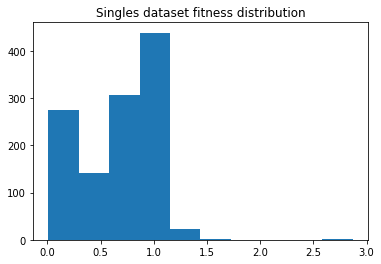

In [87]:
plt.hist(target_values_singles)
plt.title("Singles dataset fitness distribution")
plt.show()

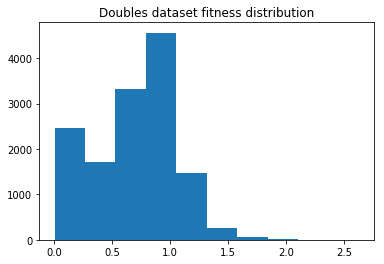

In [88]:
plt.hist(target_values_doubles)
plt.title("Doubles dataset fitness distribution")
plt.show()

In [66]:
accuracies = normal_learning(test_data_plus[1:], np.array(target_values_singles), train_size=0.7)

In [67]:
accuracies[0].correlation, accuracies[1]

SpearmanrResult(correlation=0.7033658405631522, pvalue=1.427313607202869e-54)

In [72]:
accuracies_doubles = normal_learning(test_data_doubles_plus[1:], np.array(target_values_doubles), train_size=0.7)

In [73]:
accuracies_doubles[0].correlation, accuracies_doubles[1]

(0.7731016112199357, 0.8842181119385059)

## Data-Augmentation in low-data settings

### Singles

In [101]:
training_sizes = [10, 25, 50, 75, 100, 300, 500, 1000] #, 2000, 5000, 10000]
n_components = 30

reg_score_normal = []
reg_score_augmented = []
reg_score_PCA = []
clf_score_normal = []
clf_score_augmented = []

for size in training_sizes:
    aug_run = augmented_learning(test_data_plus[1:], training_data, np.array(target_values_singles), n_components, size)
    normal_run = normal_learning(test_data_plus[1:], np.array(target_values_singles), size)
    pca_run = PCA_learning(test_data_plus[1:], np.array(target_values_singles), min(n_components,size), size)
    reg_score_normal.append(normal_run[0])
    reg_score_augmented.append(aug_run[0])
    reg_score_PCA.append(pca_run[0])
#     clf_score_normal.append(normal_run[1])
#     clf_score_augmented.append(aug_run[1])

In [102]:
[i[0] for i in reg_score_normal]

[0.2515131250852825,
 0.3705585566642241,
 0.3692484171990929,
 0.4211607915584306,
 0.4597489511211995,
 0.5681164586842038,
 0.6226004112786334,
 0.6998766619588018]

In [103]:
reg_score_normal[0][0]

0.2515131250852825

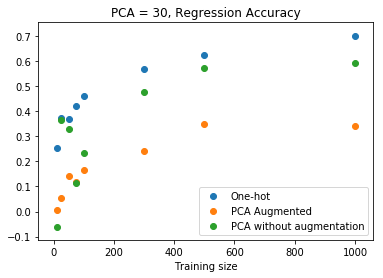

In [104]:
plt.scatter(training_sizes, [i[0] for i in reg_score_normal], label="One-hot")
plt.scatter(training_sizes, [i[0] for i in reg_score_augmented], label="PCA Augmented")
plt.scatter(training_sizes, [i[0] for i in reg_score_PCA], label="PCA without augmentation")

plt.xlabel("Training size")
plt.title("PCA = 30, Regression Accuracy")
plt.legend()
plt.savefig("PCA_30_Reg_singles.png")
plt.show()

### Doubles

In [105]:
training_sizes = [10, 25, 50, 75, 100, 300, 500, 1000] #, 2000, 5000, 10000]
n_components = 100

reg_score_normal = []
reg_score_augmented = []
reg_score_PCA = []
clf_score_normal = []
clf_score_augmented = []

for size in training_sizes:
    aug_run = augmented_learning(test_data_doubles_plus[1:], training_data, np.array(target_values_doubles), n_components, size)
    normal_run = normal_learning(test_data_doubles_plus[1:], np.array(target_values_doubles), size)
    pca_run = PCA_learning(test_data_doubles_plus[1:], np.array(target_values_doubles), min(n_components,size), size)
    reg_score_normal.append(normal_run[0])
    reg_score_augmented.append(aug_run[0])
    reg_score_PCA.append(pca_run[0])
#     clf_score_normal.append(normal_run[1])
#     clf_score_augmented.append(aug_run[1])

In [106]:
[i[0] for i in reg_score_normal]

[0.2684998719865702,
 0.3004583874905411,
 0.36929350080299633,
 0.37403545748838324,
 0.488647275455704,
 0.6324691603626504,
 0.6612468573587177,
 0.7263407220686774]

In [107]:
reg_score_normal[0][0]

0.2684998719865702

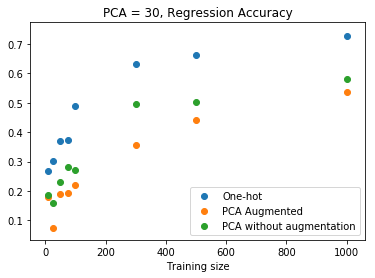

In [108]:
plt.scatter(training_sizes, [i[0] for i in reg_score_normal], label="One-hot")
plt.scatter(training_sizes, [i[0] for i in reg_score_augmented], label="PCA Augmented")
plt.scatter(training_sizes, [i[0] for i in reg_score_PCA], label="PCA without augmentation")

plt.xlabel("Training size")
plt.title("PCA = 30, Regression Accuracy")
plt.legend()
plt.savefig("PCA_30_Reg_doubles.png")
plt.show()

## UMAP Experiments

In [35]:
x_train, x_test, y_train, y_test = split_data(test_data_plus[1:], np.array(target_values_singles), train_size=1000)

In [36]:
pooled_data = np.concatenate([training_data[:1000], x_train])

In [37]:
UMAP_embedding = umap.UMAP(n_neighbors=15,
                      min_dist=0.05,
                      n_components=2,
                      metric='manhattan').fit(pooled_data)

/home/anirudh_suresh/.local/lib/python3.5/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 11 separate connected components using meta-embedding (experimental)
  n_components
/home/anirudh_suresh/.local/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [38]:
xtrain_UMAP = UMAP_embedding.transform(x_train)
xtest_UMAP = UMAP_embedding.transform(x_test)

In [39]:
pooled_UMAP = UMAP_embedding.transform(pooled_data)

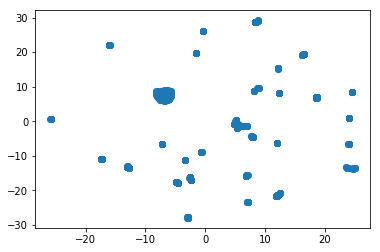

In [40]:
plt.scatter(pooled_UMAP[:, 0], pooled_UMAP[:, 1])
plt.show()

In [41]:
Reg = GradientBoostingRegressor()
Reg.fit(xtrain_UMAP, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
Reg.score(xtest_UMAP, y_test)

-0.12780815269799883

In [43]:
UMAP_sarkisyan = UMAP_embedding.transform(sarkisyan_data)

NameError: name 'sarkisyan_data' is not defined

In [554]:
# UMAP_sarkisyan = UMAP_embedding.transform(sarkisyan_data)

X_train, X_test, y_train, y_test = train_test_split(UMAP_sarkisyan, sarkisyan['function'], 
                                                   test_size = 0.3, random_state=10)

naiveClf = RandomForestClassifier()
naiveClf.fit(X_train, y_train)
clf_score = naiveClf.score(X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(UMAP_sarkisyan, sarkisyan['quantitative_function'], 
                                               test_size = 0.3, random_state=10)
naiveReg = RandomForestRegressor()
naiveReg.fit(X_train, y_train)
reg_score = naiveReg.score(X_test, y_test)

//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda/envs/ML_env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [555]:
clf_score

0.5135030615533355

In [556]:
reg_score

-0.24899542340754088

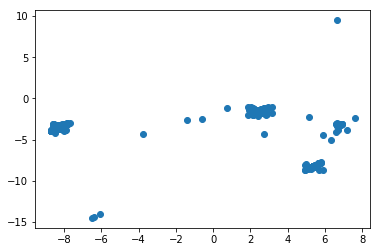

In [558]:
plt.scatter(UMAP_sarkisyan[:,0][:10000], UMAP_sarkisyan[:, 1][:10000])
plt.show()

In [548]:
UMAP_sarkisyan_20 = UMAP_sarkisyan.copy()
ortholog_umap_20 = a.copy()

This concludes the pre-processing we need to do on the data.

## 2.  Training the model
We now move on to define our neural network. This is essentially a vanilla VAE in keras (with some optimization on hyperparameters). For optimization purposes we define a callback function that reports the predictive power of the model in the end of each epoch. Note that while this passes the -test data- through the model, it is kosher because we never pass in the values we are actually interested in and the network is not in "training phase", i.e. no weights are updated during this pass. 

In [35]:
class rho_vs_mutants():
    def __init__(self,mutants,test_set_size,aa_size,sequence_size):
        self.mutants=mutants
        self.sample_size=test_set_size
        self.aa_size=aa_size
        self.sequence_size=sequence_size
        self.scores=[]
        self.count_batch=0
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    #This allows us to track the "progress" of the model on different epochs
    def on_epoch_end(self,model,batch,logs):
        x_decoded=model(test_data_plus[0:self.sample_size],batch_size=batch_size)
        digit = x_decoded[0].reshape(self.aa_size,self.sequence_size)
        digit_wt = normalize(digit,axis=0, norm='l1')
        wt_prob=compute_log_probability(digit,digit_wt)
        fitnesses=[]
        for sample in range(1,self.sample_size):
            digit = x_decoded[sample].reshape(self.aa_size,self.sequence_size)
            digit = normalize(digit,axis=0, norm='l1')
            fitness=compute_log_probability(test_data_plus[sample].reshape(self.aa_size,self.sequence_size),digit)-wt_prob
            fitnesses.append(fitness)
        print (","+str(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])))
        self.scores.append(spearmanr(fitnesses,target_values_singles[:self.sample_size-1])[0])

Now we are ready to specify the network architecture, this is adapted from [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py).

In [36]:
# torch.sum(1 + model.z_log_var - (model.z_mean)**2 - torch.exp(model.z_log_var),-1)

In [37]:
PRUNED_SEQ_LENGTH

96

In [42]:
batch_size = 20
original_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
output_dim=len(ORDER_LIST)*PRUNED_SEQ_LENGTH
latent_dim = 2
intermediate_dim=250
nb_epoch = 10
epsilon_std = 1.0
np.random.seed(42)  

loss1 = nn.CrossEntropyLoss()

def vae_loss(x_true, x_decoded_mean, z_mean, z_log_var):
    xent_loss = original_dim * loss1(x_decoded_mean, x_true)
    kl_loss = -0.5 * torch.sum(1 + z_log_var - (z_mean)**2 - torch.exp(z_log_var))
#     print ("xent loss: ", xent_loss)
#     print ("KL loss: ", kl_loss)
    return (xent_loss + kl_loss), xent_loss, kl_loss

And run it through our training data.

In [43]:
training_size = 50000 #so batchingw orks
x_train=training_data[:training_size] #this needs to be divisible by batch size and less than or equal to dataset size
x_train = x_train.astype('float32')
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))


In [44]:
vae_type = 'full'

In [45]:
if vae_type == 'full':
    print ("training on full")
    univ_dropout = [0.2]*3
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout

    layers_enc = nn.ModuleList([nn.Linear(original_dim,intermediate_dim),nn.Dropout(dropout_enc[0]),nn.ELU()])
    for i in range(2):
        layers_enc.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_enc.append(nn.Dropout(dropout_enc[i+1]))
        layers_enc.append(nn.ELU())

    layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),nn.Dropout(dropout_dec[0]),nn.ELU()])
    for i in range(2):
        layers_dec.append(nn.Linear(intermediate_dim,intermediate_dim))
        layers_dec.append(nn.Dropout(dropout_dec[i+1]))
        layers_dec.append(nn.ELU())

    layers_dec.append(nn.Linear(intermediate_dim,output_dim))

    layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
elif vae_type == 'conv':
    out_conv_enc = [50,100]
    kernels_enc = [3,5]
    dilations_enc = [1,3]
    maxpools_enc = [4,3]
    paddings_enc = [(5,5,0,0)]
    
    out_lin_enc = [100,500]
    dropout_enc = [0.2,0.2]
    
    out_lin_dec = [100,150]
    dropout_dec = [0.2,0.2]
    
    layers_enc_pre_view = nn.ModuleList([nn.Conv1d(len(ORDER_LIST),out_conv_enc[0],kernels_enc[0],stride=1,dilation=dilations_enc[0]),
                                nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[0],padding=0),
                                nn.ZeroPad2d(paddings_enc[0]),
                                nn.Conv1d(out_conv_enc[0],out_conv_enc[1],kernels_enc[1],stride=1,dilation=dilations_enc[1]),
                                nn.ELU(),
#                                 nn.MaxPool1d(4,padding=0),
#                                 nn.ZeroPad2d((5,5,0,0)),
#                                 nn.Conv1d(out_conv_enc[1],out_conv_enc[2],kernels_enc[2],stride=1,dilation=dilations_enc[2]),
#                                 nn.ELU(),
                                nn.MaxPool1d(maxpools_enc[1],padding=0)])
    
    inp_len = PRUNED_SEQ_LENGTH
    paddings_enc.append((0,0,0,0))
    for i in range(len(out_conv_enc)):
      inp_len = conv_size_func(inp_len,dilations_enc[i],kernels_enc[i])
      inp_len = inp_len//maxpools_enc[i]
      inp_len += (paddings_enc[i][0]+paddings_enc[i][1])
    
    enc_view = inp_len*out_conv_enc[-1]
    print('post-convolutional size is ', enc_view)
    
    layers_enc_post_view = nn.ModuleList([nn.Linear(enc_view,out_lin_enc[0]),
                                          nn.Dropout(dropout_enc[0]),
                                          nn.ELU(),
                                          nn.Linear(out_lin_enc[0],out_lin_enc[1]),
                                          nn.Dropout(dropout_enc[1]),
                                          nn.ELU()])
    
    layers_dec = nn.ModuleList([nn.Linear(latent_dim,out_lin_dec[0]),
                                nn.Dropout(dropout_dec[0]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[0],out_lin_dec[1]),
                                nn.Dropout(dropout_dec[1]),
                                nn.ELU(),
                                nn.Linear(out_lin_dec[1],output_dim)])
    
    layers_ae = nn.ModuleList([nn.Linear(out_lin_enc[-1],latent_dim),nn.Linear(out_lin_enc[-1],latent_dim)])
elif vae_type == 'rec':
    univ_dropout = [0.2]*2
    dropout_enc = univ_dropout
    dropout_dec = univ_dropout
    hid_size = [20,10]
    dec_lin = False
    
    num_layers = 2
    num_layers_dec = 2
    bid = True
    num_dirs = 2 if bid else 1
    
   
    layers_enc = nn.ModuleList([nn.RNN(len(ORDER_LIST),hid_size[0],num_layers=num_layers,batch_first=True,dropout=univ_dropout[0],bidirectional=bid)])


    if dec_lin:
      layers_post_rec_enc = nn.ModuleList([nn.Linear(164,intermediate_dim),
                                         nn.Dropout(dropout_enc[0]),
                                         nn.ELU(),
                                         nn.Linear(intermediate_dim,intermediate_dim),
                                         nn.Dropout(dropout_enc[1]),
                                         nn.ELU()]) # for now, not being used in rec model


  #     layers_pre_rec_dec = nn.ModuleList([nn.Linear(latent_dim,100),
  #                                         nn.Dropout(dropout_dec[0]),
  #                                         nn.ELU()])
  #     # 25 below bc bidirectional 2 layers means we have to divide 100 by 2*2
  #     layers_dec = nn.ModuleList([nn.RNN(50,25,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)])
  #     layers_post_rec_dec = nn.ModuleList([nn.Linear(25*2,len(ORDER_LIST))])

  #     layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,intermediate_dim),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim,intermediate_dim*2),
                                  nn.Dropout(.2),
                                  nn.ELU(),
                                  nn.Linear(intermediate_dim*2,output_dim)])
      
      layers_dec_post_rec = 0
    
      layers_ae = nn.ModuleList([nn.Linear(intermediate_dim,latent_dim),nn.Linear(intermediate_dim,latent_dim)])
    
    else: # dec_lin = False
      layers_post_rec_enc = 0
      
      layers_dec = nn.ModuleList([nn.Linear(latent_dim,hid_size[1]),nn.RNN(len(ORDER_LIST),hid_size[1],num_layers=num_layers_dec,batch_first=True,dropout=univ_dropout[1],bidirectional=bid)])
      
      layers_dec_post_rec = nn.ModuleList([nn.Linear(hid_size[1]*num_dirs,len(ORDER_LIST))])
      
      layers_ae = nn.ModuleList([nn.Linear(hid_size[0],latent_dim),nn.Linear(hid_size[0],latent_dim)])
      
      

training on full


In [46]:
losses_train = []
losses_test = []
accuracies_train = []
accuracies_test = []
xents_train = []
xents_test = []
kls_train = []
kls_test = []

if vae_type == 'full':
    print ("training full")
    model = VAE(layers_enc,layers_ae,layers_dec)

    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,len(ORDER_LIST)*PRUNED_SEQ_LENGTH) # 1968)

        train = torch.Tensor(train)

        
        
        for batch in train:
            out = model(batch)

            batch = batch.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,_,_ = vae_loss(batch,out,model.z_mean,model.z_log_var)
            
            optimizer.zero_grad()
            loss.backward()  
            optimizer.step()
            
        model.eval()

        out_train = model(torch.Tensor(x_train_data))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,_,_ = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val,_,_ = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
        
        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

elif vae_type == 'conv':
    print ("conv")
    model = VAE_conv(layers_enc_pre_view,enc_view,layers_enc_post_view,layers_ae,layers_dec)
        
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.001)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)

    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)

    for epoch in range(nb_epoch):
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = torch.Tensor(train)
        train = train.transpose(-2,-1)

        for batch in train:
            out = model(batch)

            batch = batch.transpose(-2,-1).reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
            batch = torch.argmax(batch,1)
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,_,_ = vae_loss(batch,out,model.z_mean,model.z_log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        out_train = model(torch.Tensor(x_train_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_train = torch.Tensor(out_train)
        out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_train = torch.argmax(out_train,dim=1)
        bool_train = (classpreds_train==ins_train)
        class_acc_train = bool_train.sum().item()/bool_train.shape[0]

        out_val = model(torch.Tensor(x_val_data).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)).transpose(-2,-1))
        out_val = torch.Tensor(out_val)
        out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        classpreds_val = torch.argmax(out_val,dim=1)
        bool_val = (classpreds_val==ins_val)
        class_acc_val = bool_val.sum().item()/bool_val.shape[0]

        loss_train,_,_ = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
        loss_val,_,_ = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)

        losses_train.append(loss_train)
        losses_test.append(loss_val)
        accuracies_train.append(class_acc_train)
        accuracies_test.append(class_acc_val)
        
        print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
              %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
        
elif vae_type == 'rec':
    print ("rec")
    if lang_mod:
        print("language model training")
    else:
        print("vae training")
    
    alpha = 50000
    beta = 0.005
    print('KL annealing terms: alpha = {}, beta = {}'.format(alpha,beta))
        
    model = VAE_rec(layers_enc,layers_post_rec_enc,layers_ae,0,layers_dec,layers_dec_post_rec)
    
    if cuda:
        model = model.cuda()
    
    prams = list(model.parameters())

    optimizer = torch.optim.Adam(prams, lr = 0.01)

    x_train_data, x_val_data = train_test_split(x_train, test_size = 0.1)
    
#     print('FAKE TRAINING SET TO ASSESS REC VALIDITY')
#     x_train_data = np.array([[0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]*3690000).reshape(45000,1968)
    
#     import pdb; pdb.set_trace()
    
    ins_train = x_train_data.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_train = torch.Tensor(ins_train)
    ins_train = torch.argmax(ins_train,1)

    ins_val = x_val_data.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))
    ins_val = torch.Tensor(ins_val)
    ins_val = torch.argmax(ins_val,1)
    
    ins_train = create_tensor(ins_train,gpu=cuda)
    ins_val = create_tensor(ins_val,gpu=cuda)
    
    
#     ## Printing model perf before
#     model.eval()
            
#     out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
#     out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

#     classpreds_train = torch.argmax(out_train,dim=1)
#     bool_train = (classpreds_train==ins_train)
#     class_acc_train = bool_train.sum().item()/bool_train.shape[0]

#     out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
#     out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

#     classpreds_val = torch.argmax(out_val,dim=1)
#     bool_val = (classpreds_val==ins_val)
#     class_acc_val = bool_val.sum().item()/bool_val.shape[0]

#     loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
#     kl_train = sigmoid(beta*(-alpha))*kl_train # annealing
#     loss_train = xent_train + kl_train # annealing
#     loss_val,xent_val,kl_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
#     kl_val = sigmoid(beta*(-alpha))*kl_val # annealing
#     loss_val = xent_val + kl_val # annealing

#     losses_train.append(loss_train.item())
#     losses_test.append(loss_val.item())
#     accuracies_train.append(class_acc_train)
#     accuracies_test.append(class_acc_val)
#     xents_train.append(xent_train.item())
#     xents_test.append(xent_val.item())
#     kls_train.append(kl_train.item())
#     kls_test.append(kl_val.item())

#     print('Pre-training | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
#           %( loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )
    
    for epoch in range(nb_epoch):
        print('Epoch {}'.format(epoch))
        
        model.train()

        train = np.random.permutation(x_train_data)
        train = train.reshape(-1,batch_size,PRUNED_SEQ_LENGTH,len(ORDER_LIST))

        train = create_tensor(torch.Tensor(train),gpu=cuda)

        xents = []
        kls = []
        
        num_dum = -1

        optimizer.zero_grad()
        
        for batch in train:
            num_dum += 1
            out = model(batch,True,lang_mod)
            
#             import pdb; pdb.set_trace()
            batch = torch.argmax(batch,-1)
            batch = batch.reshape(-1)
                        
            out = out.reshape(batch_size*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

            loss,xent,kl = vae_loss(batch,out,model.z_mean,model.z_log_var)
            mult = epoch*len(x_train_data)/batch_size + num_dum # annealing
            kl = sigmoid(beta*(mult-alpha))*kl # annealing
            loss = xent + kl # annealing
            if num_dum % 1000 == 0:
                print((batch==torch.argmax(out,-1)).sum().item()/(batch_size*PRUNED_SEQ_LENGTH*1.0))
            xents.append(xent)
            kls.append(kl)

            if lang_mod:
                xent.backward()
            else:
                loss.backward()   
            
#         for layer, paramval in model.named_parameters():
#             print(layer,paramval.grad)
            
        optimizer.step()
            
#         import pdb; pdb.set_trace()
        print('xent mean is:',torch.stack(xents).mean().item())
        print('kl mean is:',torch.stack(kls).mean().item())

#         model.eval()
        
# #         import pdb; pdb.set_trace()
#         out_train = model(create_tensor(torch.Tensor(x_train_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
#         out_train = out_train.reshape(len(x_train_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

#         classpreds_train = torch.argmax(out_train,dim=1)
#         bool_train = (classpreds_train==ins_train)
#         class_acc_train = bool_train.sum().item()/bool_train.shape[0]

#         out_val = model(create_tensor(torch.Tensor(x_val_data),gpu=cuda).reshape(-1,PRUNED_SEQ_LENGTH,len(ORDER_LIST)),False,lang_mod)
#         out_val = out_val.reshape(len(x_val_data)*PRUNED_SEQ_LENGTH,len(ORDER_LIST))

#         classpreds_val = torch.argmax(out_val,dim=1)
#         bool_val = (classpreds_val==ins_val)
#         class_acc_val = bool_val.sum().item()/bool_val.shape[0]

#         loss_train,xent_train,kl_train = vae_loss(ins_train,out_train,model.z_mean,model.z_log_var)
#         mult = epoch*len(x_train_data)/batch_size + num_dum # annealing
#         kl_train = sigmoid(beta*(mult-alpha))*kl_train # annealing
#         loss_train = xent_train + kl_train # annealing
#         loss_val,xent_val,kl_val = vae_loss(ins_val,out_val,model.z_mean,model.z_log_var)
#         kl_val = sigmoid(beta*(mult-alpha))*kl_val # annealing
#         loss_val = xent_val + kl_val # annealing
        
#         losses_train.append(loss_train.item())
#         losses_test.append(loss_val.item())
#         accuracies_train.append(class_acc_train)
#         accuracies_test.append(class_acc_val)
#         xents_train.append(xent_train.item())
#         xents_test.append(xent_val.item())
#         kls_train.append(kl_train.item())
#         kls_test.append(kl_val.item())
        
#         print(classpreds_train)
#         print(classpreds_val)
        
#         print('Epoch %s | Training Loss: %s, Training Accuracy: %s, Validation Loss: %s, Validation Accuracy: %s'
#               %( epoch, loss_train.item(), class_acc_train, loss_val.item(), class_acc_val ) )

training full
Epoch 0 | Training Loss: 51845.8828125, Training Accuracy: 0.5613212962962963, Validation Loss: 51856.19140625, Validation Accuracy: 0.5625208333333334
Epoch 1 | Training Loss: 59084.19921875, Training Accuracy: 0.5698942129629629, Validation Loss: 59098.73046875, Validation Accuracy: 0.5718708333333333
Epoch 2 | Training Loss: 60201.77734375, Training Accuracy: 0.5765546296296297, Validation Loss: 60201.64453125, Validation Accuracy: 0.5805270833333334
Epoch 3 | Training Loss: 70057.5, Training Accuracy: 0.5996157407407408, Validation Loss: 70068.3984375, Validation Accuracy: 0.6023125
Epoch 4 | Training Loss: 70746.8984375, Training Accuracy: 0.6048523148148148, Validation Loss: 70770.703125, Validation Accuracy: 0.6059270833333333
Epoch 5 | Training Loss: 71713.140625, Training Accuracy: 0.6109006944444444, Validation Loss: 71734.3671875, Validation Accuracy: 0.6121541666666667
Epoch 6 | Training Loss: 68660.671875, Training Accuracy: 0.62168125, Validation Loss: 68688

MemoryError: 

Let's explore the latent space

In [47]:
fit_xtrain = model(torch.Tensor(test_data_plus)).detach()
z_means = model.z_mean.detach()

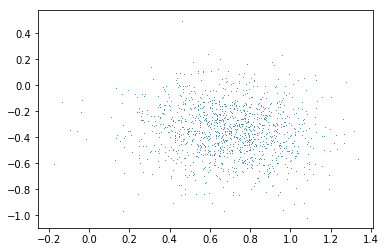

In [48]:
transposed_zmeans = np.array(z_means).transpose()

plt.scatter(transposed_zmeans[0], transposed_zmeans[1], s = 1, linewidths = 0)
plt.show()

In [49]:
from sklearn.cluster import KMeans

z_means_np = np.array(z_means)
kmeans = KMeans(n_clusters=12, random_state=1).fit(z_means_np)

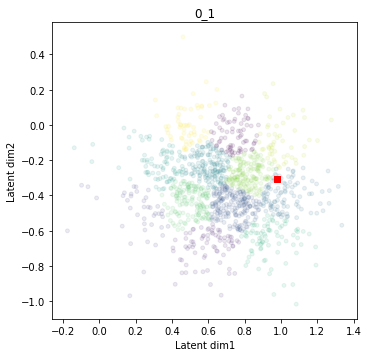

In [50]:
sample_points=len(z_means_np)

latent_dim = 2
fig = plt.figure(figsize=(12,12))
counter=0
cmap=kmeans.labels_
for z1 in range(latent_dim):
    for z2 in range(z1+1,latent_dim):
        counter+=1
        fig.add_subplot(latent_dim,latent_dim,counter)
        plt.title(str(z1)+"_"+str(z2))
        plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c=cmap[::-1], s = 15, alpha=0.1,marker="o")
#         plt.scatter(z_means_np[:, z1][::-1], z_means_np[:, z2][::-1],c="y" ,alpha=0.3,marker="o")
        plt.scatter(z_means_np[0][z1], z_means_np[0][z2],c="r" ,alpha=1,s=40,marker="s")
        plt.xlabel("Latent dim"+str(z1+1))
        plt.ylabel("Latent dim"+str(z2+1));
plt.savefig("Try2_originalDropout.png")


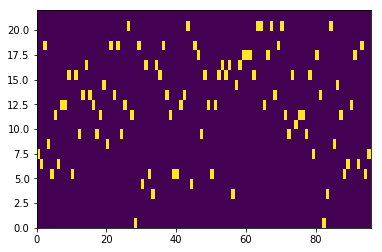

In [51]:
plt.pcolor(x_train[0].reshape(PRUNED_SEQ_LENGTH, len(ORDER_LIST)).transpose(1, 0))
plt.show()

# Training a classifier over the latent space

In [85]:
class_x = test_data_plus
class_y = np.array(target_values_singles)
print('USING SINGLES')

# class_x = test_data_doubles_plus
# class_y = np.array(target_values_doubles)
# print('USING DOUBLES')

In [86]:
fit_total = model(torch.Tensor(class_x)).detach()
latent_data = model.z_mean.detach()

In [87]:
fit_total.shape

torch.Size([1188, 2112])

In [88]:
latent_data.shape

torch.Size([1188, 2])

In [89]:
fit_total

tensor([[ 1.2532e+00, -4.6472e+00, -9.6657e-01,  ..., -2.1357e+01,
         -2.2893e+01,  1.3012e+01],
        [ 3.2795e-01, -5.9003e+00, -2.4389e-01,  ..., -2.7682e+01,
         -2.9785e+01,  1.9280e+01],
        [ 8.0421e-01, -5.3887e+00, -1.8160e+00,  ..., -2.0505e+01,
         -2.0667e+01,  1.2343e+01],
        ...,
        [ 1.2165e+00, -5.6005e+00, -2.7033e+00,  ..., -2.0456e+01,
         -2.1571e+01,  1.2711e+01],
        [ 4.7981e-01, -5.3204e+00, -2.7551e+00,  ..., -2.0349e+01,
         -2.0126e+01,  1.2241e+01],
        [ 7.4972e-01, -3.1484e+00, -2.4708e-02,  ..., -2.1908e+01,
         -2.3368e+01,  1.2862e+01]])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(np.array(latent_data[1:]), class_y, 
                                                   test_size = 0.3, random_state=10)

In [94]:
latentReg = GradientBoostingRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

-0.06669966221081558

In [95]:
predic_train = latentReg.predict(X_train)
predic_test = latentReg.predict(X_test)
spearmanr(predic_train, y_train), spearmanr(predic_test, y_test)

(SpearmanrResult(correlation=0.6337760256217291, pvalue=1.9631259322175244e-94),
 SpearmanrResult(correlation=-0.020525429806018545, pvalue=0.6991284732867271))

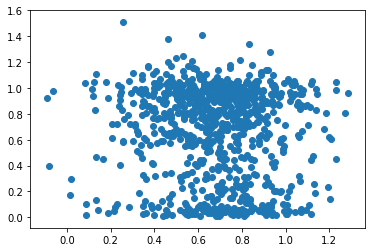

In [96]:
plt.scatter(X_train[:,0], y_train)
plt.show()

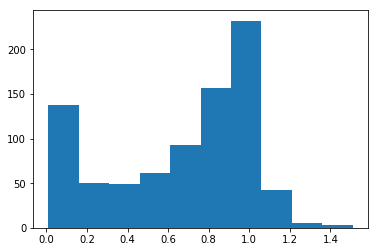

In [97]:
plt.hist(y_train)
plt.show()

In [98]:
px_data = np.concatenate([np.array(fitnesses).reshape(-1, 1), np.array(fitnesses_vs_wt).reshape(-1, 1),
                                                                       np.array(fitnesses_vs_avg).reshape(-1, 1)], axis = 1)

In [99]:
total_data = np.concatenate([latent_data, torch.Tensor(px_data)], axis = 1)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(np.array(total_data)[1:], class_y, 
                                                   train_size = 1000, random_state=10)

latentReg = GradientBoostingRegressor()
latentReg.fit(X_train, y_train)
# latentReg.predict(X_test)
latentReg.score(X_test, y_test)

-0.020851399512535892

In [105]:
spearmanr(latentReg.predict(X_test), y_test)

SpearmanrResult(correlation=0.07564172558234476, pvalue=0.3035152749525157)

## Calculating P(X)

In [64]:
m = torch.nn.Softmax()

In [65]:
PRUNED_SEQ_LENGTH

96

In [66]:
reshaped_fit = np.array(m(fit_total.reshape(len(fit_total) * PRUNED_SEQ_LENGTH, 
                                            len(ORDER_LIST))).reshape(len(fit_total), PRUNED_SEQ_LENGTH, len(ORDER_LIST))
                        .transpose(2, 1))







/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


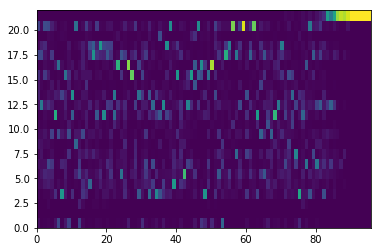

In [67]:
plt.pcolor(reshaped_fit[0])

In [68]:
fit_total.shape

torch.Size([1188, 2112])

In [69]:
len(ORDER_LIST)

22

In [70]:
digit_wt

NameError: name 'digit_wt' is not defined

In [84]:
sample_size=len(fit_total)
sample_for_averging_size=100
sequence_size=PRUNED_SEQ_LENGTH
digit_size = len(ORDER_LIST)

digit = reshaped_fit[0]#fit_xtrain_softmax_reshaped[0]
digit_wt = digit
digit_wt = normalize(digit,axis=0, norm='l1')
# print (digit_wt)


wt_prob=compute_log_probability(reshaped_fit[0].reshape(digit_size, sequence_size),digit_wt)
#print ("wt_log_prob: ", wt_prob)

wt_probs=[]
digit_avg=np.zeros((digit_size, sequence_size))


sample_indices=random.sample(range(sample_size),sample_for_averging_size)

counter=0
for sample in sample_indices:
    digit = reshaped_fit[sample]
#     print (digit)
#     print (digit_avg)
#     digit_wt_i = normalize(digit,axis=0, norm='l1')
    digit_wt_i = digit
    
#     print (digit_wt_i)
    
    digit_avg+=np.array(digit_wt_i) * 1. / sample_for_averging_size
    
    wt_p=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit_wt_i)
    wt_probs.append(wt_p)
    counter+=1
    
average_wt_p=np.mean(wt_probs)

fitnesses_vs_wt=[]
fitnesses=[] #first plug in just the sequences
fitnesses_vs_avg=[] 

for sample in range(0,sample_size):
    digit = reshaped_fit[sample]
#     digit = normalize(digit,axis=0, norm='l1')
    
    fitness=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit)-wt_prob
    fitnesses.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit_wt)-wt_prob
    fitnesses_vs_wt.append(fitness)
    
    fitness=compute_log_probability(reshaped_fit[sample].reshape(digit_size, sequence_size),digit_avg)-average_wt_p
    fitnesses_vs_avg.append(fitness)
    
    
test_data = class_y
print ("Spearman",spearmanr(fitnesses_vs_avg[1:],test_data[:sample_size]))
print ("Pearson", pearsonr(fitnesses_vs_avg[1:],test_data[:sample_size]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses_vs_wt[1:],test_data[:sample_size]))
print ("Pearson", pearsonr(fitnesses_vs_wt[1:],test_data[:sample_size]))
print ('------------------------------')
print ("Spearman",spearmanr(fitnesses[1:],test_data[:sample_size]))
print ("Pearson", pearsonr(fitnesses[1:],test_data[:sample_size]))

/home/anirudh_suresh/VAE_protein_function/helper_tools.py:115: RuntimeWarning: divide by zero encountered in log
  log_prod_mat=np.log(prod_mat)


Spearman SpearmanrResult(correlation=-0.03829097038270857, pvalue=0.18739412840171427)
Pearson (-0.016957898642099577, 0.5594392401590145)
------------------------------
Spearman SpearmanrResult(correlation=-0.0028865666716175616, pvalue=0.9208636173646015)
Pearson (0.014565177274013848, 0.6161529720304042)
------------------------------
Spearman SpearmanrResult(correlation=-0.009660489875804291, pvalue=0.7395203024930571)
Pearson (-0.00929920720904929, 0.7489276149137767)


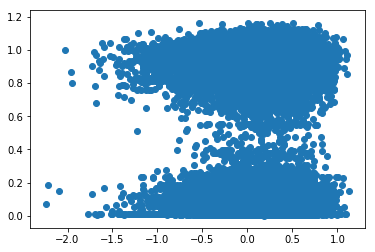

In [835]:
plt.scatter(fitnesses_vs_wt, sarkisyan['quantitative_function'][1:sample_size])

In [825]:
reshaped_fit_sarkisyan[0].reshape(digit_size, sequence_size).T

AttributeError: 'Tensor' object has no attribute 'T'